In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
from zlib import crc32
from copy import deepcopy
from tqdm import tqdm

from code.baesan_neural_network import BayesanNeuralNetwork



In [4]:
theory = crc32('Никитин'.lower().encode('utf-8'))%5+1
practice = crc32('Nikitin'.lower().encode('utf-8'))%3+1
print(theory, practice)

5 2


Воспользуемся кодом, реализованным в прошлой домашней работе для баесовского вывода нейросеток. Остаётся реализовать логистическую регрессию. 

In [5]:
batch_size = 32

In [6]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('./data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.MNIST('./data/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [7]:
class LogisticClassifier(nn.Module):
    def __init__(self, n_classes=10):
        super(LogisticClassifier, self).__init__()
        self.linear = nn.Linear(28*28, n_classes)
        self.nonlinearity = nn.LogSoftmax(dim=-1)
        self.loss = nn.NLLLoss()
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.nonlinearity(self.linear(x))

In [15]:
def prune_params(params, lam):
    var_pruned_params = deepcopy(params)
    rand_pruned_params = deepcopy(params)
    w_mean = params['linear_weight_mean']
    w_std = (1 + params['linear_weight_rho'].exp()).log()
    b_mean = params['linear_bias_mean']
    b_std = (1 + params['linear_bias_rho'].exp()).log()
    w_mask = torch.abs(w_mean/w_std) < lam
    b_mask = torch.abs(b_mean/b_std) < lam
    var_pruned_params['linear_weight_mean'][w_mask] = 0.
    var_pruned_params['linear_bias_mean'][b_mask] = 0.
    idx = torch.randperm(w_mask.nelement())
    w_mask = w_mask.view(-1)[idx].view(w_mask.size())
    idx = torch.randperm(b_mask.nelement())
    b_mask = b_mask.view(-1)[idx].view(b_mask.size()) 
    rand_pruned_params['linear_weight_mean'][w_mask] = 0.
    rand_pruned_params['linear_bias_mean'][b_mask] = 0.
    deleted = float(b_mask.sum() + w_mask.sum())/(len(b_mask) + w_mask.shape[0]*w_mask.shape[1])
    return var_pruned_params, rand_pruned_params, deleted

In [51]:
device = 'cuda:0'
nlll_loss = nn.NLLLoss()
var_logistic = BayesanNeuralNetwork(LogisticClassifier())

In [52]:
optimizer = optim.Adam(var_logistic.parameters(), lr=0.001)
var_logistic.train()
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    loss_error = nlll_loss(var_logistic(data), target)
    loss_prior = var_logistic.prior_loss() 
    loss = loss_error + loss_prior*1e-2
    loss.backward()
    optimizer.step()

In [53]:
source_params = deepcopy(var_logistic.state_dict())

In [54]:
sparsity = []
var_performance = []
rand_performance = []
for lam in tqdm((np.exp(np.linspace(0, 10, 31)) - 1)/1e4):
    pruned_params, rand_parms,  deleted = prune_params(source_params, lam)
    sparsity.append(deleted)
    
    var_logistic.load_state_dict(pruned_params)
    var_logistic.eval()
    n_correct = 0
    n_total = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        
        output = torch.argmax(var_logistic(data), dim=-1)
        n_correct += (output == target).float().sum()
        n_total += len(output)
    var_performance.append(n_correct/n_total)
    
    var_logistic.load_state_dict(rand_parms)
    var_logistic.eval()
    n_correct = 0
    n_total = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        if batch_idx > 100: break
        output = torch.argmax(var_logistic(data), dim=-1)
        n_correct += (output == target).float().sum()
        n_total += len(output)
    rand_performance.append(n_correct/n_total)

100%|██████████| 31/31 [01:00<00:00,  2.00s/it]


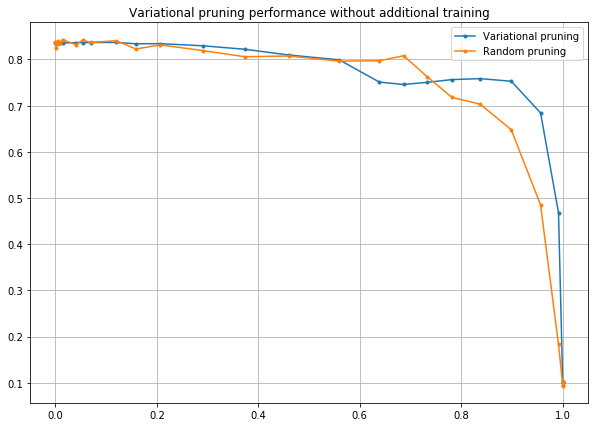

In [56]:
plt.figure(figsize=(10, 7))
plt.title('Variational pruning performance without additional training')
plt.grid()
plt.plot(sparsity, var_performance, '.-', label='Variational pruning')
plt.plot(sparsity, rand_performance, '.-', label='Random pruning')
plt.legend()
plt.show()

### Выводы:

Имеется некоторая проблема, свзанная с реализацией алгоритма, которая приводит к падению качества при степени разреживания около $.6$. 

Однако, даже проведенный эксперимент показывает, что баесовское удаление параметров работает луче, чем случайное и позволят эффктивно решать задачу при разреженности близкой к 1. 